In [274]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pickle

import scipy
from scipy.stats import chi2_contingency, mannwhitneyu

import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectFromModel,SelectKBest, RFE, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn import svm

import matplotlib.pyplot as plt
%matplotlib inline

# Formatting

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\\usepackage{subdepth} \\usepackage{type1cm}"

# Functions

In [3]:
def t_score(X, y):
    X0 = X[y == 0]
    X1 = X[y == 1]
    
    mu0 = np.mean(X0, axis = 0)
    mu1 = np.mean(X1, axis = 0)
    
    s0 = np.std(X0, axis = 0)
    s1 = np.std(X1, axis = 0)
    
    return np.abs(mu0 - mu1)/(s0 + s1)

def z_score(X):
    mu = np.mean(X, axis = 0)
    s = np.std(X, axis = 0)
    
    return (X - mu)/s

def mwu_score(X, y):
    m, n = X.shape
    
    score = np.zeros(n)
    for i in range(n):
        score[i] = scipy.stats.mannwhitneyu(X[:,i], y)[0]
        
    return score

In [4]:
def cross_val_auc(clf, X, y, n = 10):
    cv = StratifiedKFold(n_splits = n)
    
    aucs = []
    for train, test in cv.split(X, y):
        probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
    return aucs

def calc_roc_auc(model, X, y):
    y_score = model.predict_proba(X)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    
    return (fpr, tpr, roc_auc)


def plot_roc_curve(fpr, tpr, roc_auc):    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
class WeightedVotingClassifier():
    
    def __init__(self, class_score = t_score):
        self.class_score = class_score
                
        # For checking prediction input matches fit shape
        self.m = None
        self.n = None
        
        # Initialize empty before fitting        
        self.mu0 = None
        self.mu1 = None
        self.s0 = None
        self.s1 = None
        self.weights = None
        
        self.f1 = None
        
    def fit(self, X, y):        
        # For checking prediction input matches fit shape
        self.m, self.n = X.shape
        
        X0 = X[y == 0]
        X1 = X[y == 1]
    
        self.mu0 = np.mean(X0, axis = 0)
        self.mu1 = np.mean(X1, axis = 0)
        self.s0 = np.std(X0, axis = 0)
        self.s1 = np.std(X1, axis = 0)
        
        self.weights = self.class_score(X, y)
        if len(self.weights) > 1:
            self.weights = self.weights[0]
        
    def predict(self, X):
        m, n = X.shape
        assert n == self.n, "Input data does not match fit dimensions."
        
        b = (self.mu0 + self.mu1)/2
        votes = np.zeros((m, 2))
        
        for i, xg in enumerate(X):
            d0 = np.abs((xg - self.mu0)/self.s0)
            d1 = np.abs((xg - self.mu1)/self.s1)
            dx = self.weights*np.abs(xg - b)
            
            v0_ind = d0 < d1
            v1_ind = d1 <= d0
            v0 = np.sum(dx[v0_ind])
            v1 = np.sum(dx[v1_ind])
            
            votes[i,0] = v0
            votes[i,1] = v1
          
        self.f0 = votes[:,0]/np.sum(votes, axis = 1)
        self.f1 = votes[:,1]/np.sum(votes, axis = 1)
        preds = np.argmax(votes, axis = 1)
        
        return preds
    
    def predict_proba(self, X):
        self.predict(X) # Update 1 fraction weights
        return np.array([self.f0, self.f1]).T
    
    def get_params(self, deep = False):
        return {'class_score': self.class_score}

# Data Import

In [6]:
b_df = pd.read_csv("data/matrix_bronchial.csv", index_col = 0)
n_df = pd.read_csv("data/matrix_nasal.csv", index_col = 0)

In [169]:
train_df, test_df = sklearn.model_selection.train_test_split(n_df, test_size = 0.1, random_state = 12345)
(train_df.shape[0], test_df.shape[0])

(438, 49)

In [170]:
train_df.head()

,cancer,age,gender,smoker,smoking_quit,mass_size,7892501,7892502,7892503,7892504,...,8180408,8180409,8180410,8180411,8180413,8180414,8180415,8180416,8180417,8180418
geoid,,,,,,,,,,,,,,,,,,,,,
GSM2137165,0,55.449315,1,1,1,1,2.932069,4.070864,2.582677,8.008980,...,8.192856,9.052810,9.450845,5.529531,6.679835,9.514471,6.134313,4.436933,7.415813,8.880868
GSM2137427,0,73.000000,1,0,-1,1,2.579532,3.849077,2.628673,8.703568,...,7.717082,8.997296,9.193001,5.345979,6.894181,9.713782,6.178075,4.421871,7.628149,8.728245
GSM2137179,0,47.000000,0,0,-1,-1,1.763068,3.082161,2.377183,8.833297,...,7.292718,8.405972,9.083116,5.881824,6.836088,9.506780,5.330150,5.065059,7.558969,8.398418
GSM2137413,1,75.454795,1,0,1,-1,2.106988,3.650673,2.549926,8.586780,...,7.737646,8.927904,8.710354,5.387452,6.684257,9.551805,6.382070,4.400418,7.395097,8.358396
GSM2137425,0,42.000000,0,1,1,-1,1.647837,3.439473,3.247707,9.087055,...,7.148801,8.101304,8.216924,7.167894,6.526170,9.262403,5.276680,4.930786,6.754026,7.735028


# Clinical Data Classifier

In [9]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [10]:
X_train_clinical = X_train[:,0:5]
X_test_clinical = X_test[:,0:5]

## PCA

In [89]:
k = 2

pca = PCA(n_components = k)
pca_fit = pca.fit_transform(X_train_clinical)

v1, v2 = pca.explained_variance_ratio_

print("Explained variance: [{:.3f}, {:.3f}]".format(v1, v2))

Explained variance: [0.361, 0.218]


In [90]:
pca_df = pd.DataFrame(data = pca_fit, columns = ['pc1', 'pc2'], index = train_df.index)
pca_df = pd.concat([train_df["cancer"], pca_df], axis = 1)

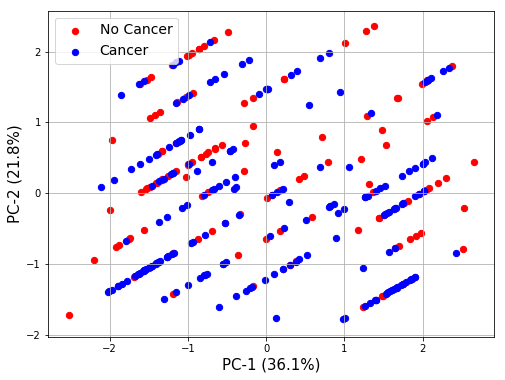

In [91]:
fig = plt.figure(figsize = (8,6))


ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("PC-1 ({:.1f}%)".format(100*v1), fontsize = 15)
ax.set_ylabel("PC-2 ({:.1f}%)".format(100*v2), fontsize = 15)

colors = ['r', 'b']
targets = [0, 1]

for target, color in zip(targets,colors):
    idx = pca_df['cancer'] == target
    ax.scatter(pca_df.loc[idx, 'pc1'], pca_df.loc[idx, 'pc2'], c = color, s = 40)
ax.legend(["No Cancer", "Cancer"])
ax.grid()

## Model Testing

### Weighted Voting

In [640]:
wv_clinical = WeightedVotingClassifier(class_score = t_score)
wv_clinical.fit(X_train_clinical, y_train)

In [641]:
scores = cross_val_score(wv_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
accuracy = np.mean(scores)

print("Mean CV Recall = {}".format(accuracy))

Mean CV Accuracy = 0.5676470588235294


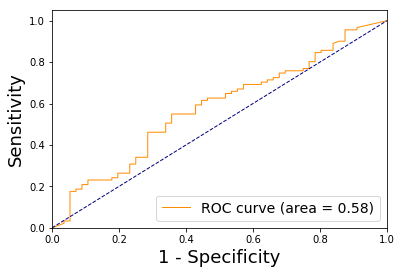

In [642]:
fpr, tpr, roc_auc = calc_roc_auc(wv_clinical, X_test_clinical, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

### Logistic Regression 

In [11]:
lr_clinical = LogisticRegression(solver = "newton-cg")
lr_clinical.fit(X_train_clinical, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
scores = cross_val_score(lr_clinical, X_train_clinical, y_train, cv = 10, scoring = "roc_auc")
accuracy = np.mean(scores)

print("Mean CV Recall = {}".format(accuracy))

Mean CV Recall = 0.6903874085246634


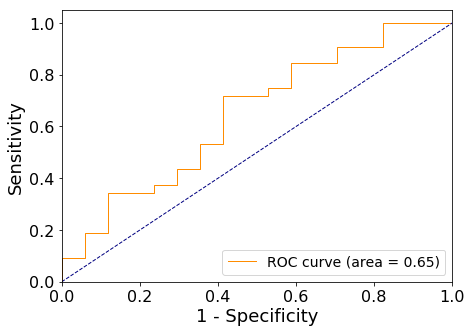

In [13]:
fpr, tpr, roc_auc = calc_roc_auc(lr_clinical, X_test_clinical, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

### SVM

In [283]:
svr_clinical = svm.SVC(C = 2.5, gamma = "auto", kernel = "rbf")
svr_clinical.fit(X_train_clinical, y_train)

SVC(C=2.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [284]:
scores = cross_val_score(svr_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
accuracy = np.mean(scores)

print("Mean CV Recall = {}".format(accuracy))

Mean CV Accuracy = 0.7117850776674306


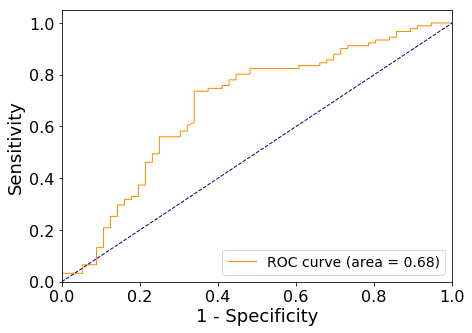

In [293]:
fpr, tpr, roc_auc = calc_roc_auc(svr_clinical, X_test_clinical, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

### Random Forest

In [140]:
rfc_clinical = RandomForestClassifier(random_state = 12345)


parameters = {
    'n_estimators': [50, 100, 500, 1000], 
    'max_depth': [1, 2, 5, 10, None],
    'criterion': ['gini', 'entropy']
}

clf = GridSearchCV(rfc_clinical, parameters, cv = 10, n_jobs = -1)
clf.fit(X_train_clinical, y_train)

clf.best_params_

/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 1000}

In [144]:
rfc_clinical = RandomForestClassifier(n_estimators = 1000,
                             max_depth = 5, 
                             criterion="gini",
                             random_state = 12345)

rfc_clinical.fit(X_train_clinical, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [145]:
scores = cross_val_score(rfc_clinical, X_train_clinical, y_train, cv = 10, scoring = "recall")
accuracy = np.mean(scores)

print("Mean CV Recall = {}".format(accuracy))

Mean CV Recall = 0.8219047619047618


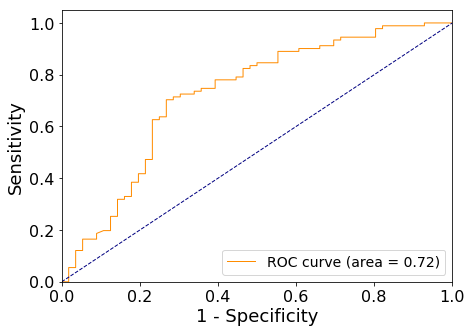

In [146]:
fpr, tpr, roc_auc = calc_roc_auc(rfc_clinical, X_test_clinical, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

# Feature and Model Selection

In [171]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [172]:
X_train_clinical = X_train[:,0:5]
X_test_clinical = X_test[:,0:5]

X_train_rna = X_train[:,5:]
X_test_rna = X_test[:,5:]

## Logistic Regression

### T-Score

In [281]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(t_score, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    lr = LogisticRegression(solver = "newton-cg")
    scores = cross_val_score(lr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6905266000037242
k = 500, Mean CV Score = 0.7547818557622479
k = 750, Mean CV Score = 0.807933448783122
k = 1000, Mean CV Score = 0.8330391225816063
k = 1500, Mean CV Score = 0.8334115412546785
k = 2250, Mean CV Score = 0.8437861944397893
k = 2750, Mean CV Score = 0.8488725024672737


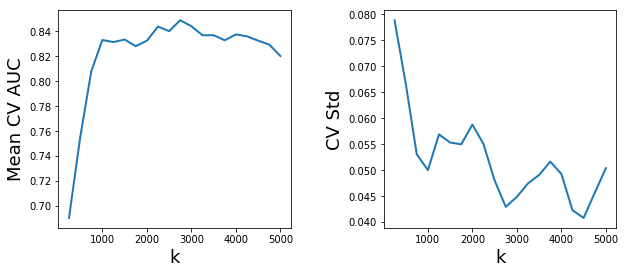

In [282]:
fig, ax = plt.subplots(1, 2, figsize=(10,4)) 
plt.subplots_adjust(wspace = 0.4)

ax1, ax2= ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

plt.show()

### F-Value

In [279]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(f_classif, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    lr = LogisticRegression(solver = "newton-cg")
    scores = cross_val_score(lr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6681377204253021
k = 500, Mean CV Score = 0.7488771577006872
k = 750, Mean CV Score = 0.8185268979386627
k = 1000, Mean CV Score = 0.8357829171554663
k = 1500, Mean CV Score = 0.8405796696646369
k = 2750, Mean CV Score = 0.849254231607173


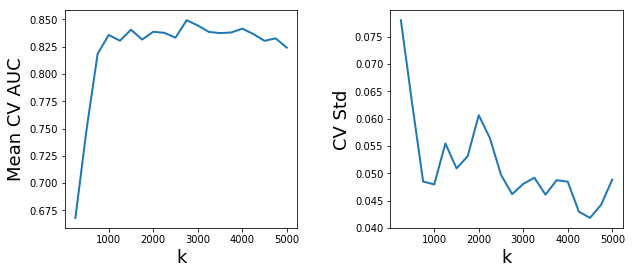

In [280]:
fig, ax = plt.subplots(1, 2, figsize=(10,4)) 
plt.subplots_adjust(wspace = 0.4)

ax1, ax2= ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

plt.show()

### Tree-Based

In [283]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])

model = ExtraTreesClassifier(n_estimators = 100, random_state = 12345)
model.fit(X_train_rna, y_train)

for i, k in enumerate(k_vals):
    
    selector = SelectFromModel(model, prefit = True, max_features = k)

    X_train_sel = selector.transform(X_train_rna)
    X_test_sel = selector.transform(X_test_rna)

    lr = LogisticRegression(solver = "newton-cg")
    scores = cross_val_score(lr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6428458372902817
k = 500, Mean CV Score = 0.6476053479321453
k = 750, Mean CV Score = 0.6818604174813325
k = 1000, Mean CV Score = 0.7283550267210398


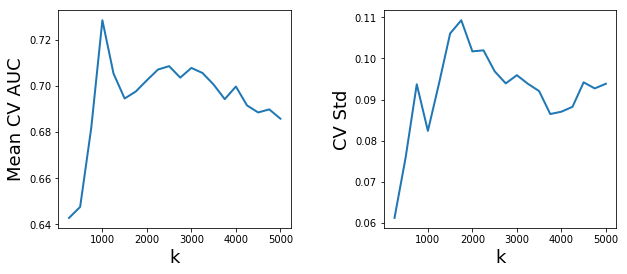

In [284]:
fig, ax = plt.subplots(1, 2, figsize=(10,4)) 
plt.subplots_adjust(wspace = 0.4)

ax1, ax2= ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

plt.show()

## SVM

### T-Score

In [285]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
    
for i, k in enumerate(k_vals):
    
    selector = SelectKBest(t_score, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    svr = svm.SVC(gamma = "auto", kernel = "rbf", probability = True)
    scores = cross_val_score(svr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.7069316425525576
k = 500, Mean CV Score = 0.7125747164962851
k = 750, Mean CV Score = 0.7299620132953466
k = 1000, Mean CV Score = 0.738008118727073


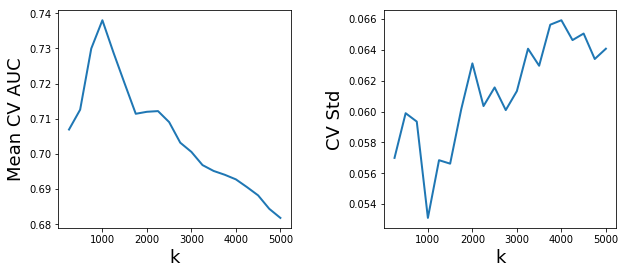

In [287]:
fig, ax = plt.subplots(1, 2, figsize=(10,4)) 
plt.subplots_adjust(wspace = 0.4)

ax1, ax2= ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

plt.show()

### F-Value

In [424]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])
    
for i, k in enumerate(k_vals):
    
    selector = SelectKBest(f_classif, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
      
    svr = svm.SVC(gamma = "auto", kernel = "rbf", probability = True)
    scores = cross_val_score(svr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.7036748412565407
k = 500, Mean CV Score = 0.7101418915144405
k = 750, Mean CV Score = 0.7303390872018323
k = 1000, Mean CV Score = 0.7369681395825186


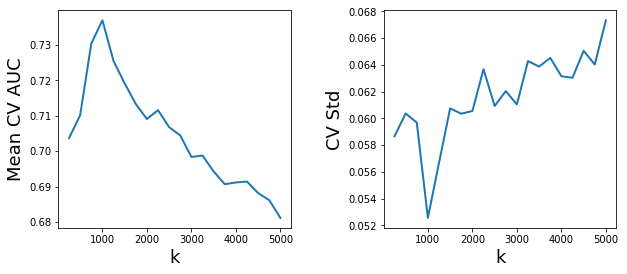

In [425]:
fig, ax = plt.subplots(1, 2, figsize=(10,4)) 
plt.subplots_adjust(wspace = 0.4)

ax1, ax2= ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

plt.show()

### Tree Based

In [426]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])

model = ExtraTreesClassifier(n_estimators = 100, random_state = 12345)
model.fit(X_train_rna, y_train)

for i, k in enumerate(k_vals):
    
    selector = SelectFromModel(model, prefit = True, max_features = k)

    X_train_sel = selector.transform(X_train_rna)
    X_test_sel = selector.transform(X_test_rna)

    svr = svm.SVC(gamma = "auto", kernel = "rbf", probability = True)
    scores = cross_val_score(svr, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6977962125020948


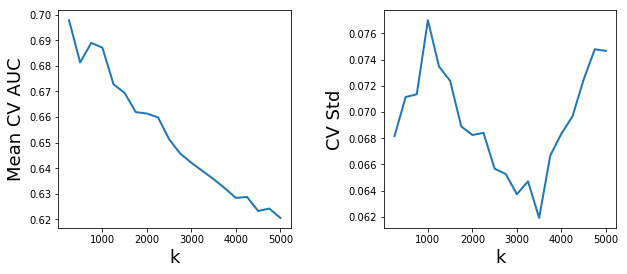

In [427]:
fig, ax = plt.subplots(1, 2, figsize=(10,4)) 
plt.subplots_adjust(wspace = 0.4)

ax1, ax2 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

plt.show()

## Random Forest

### T-Score

In [428]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(t_score, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
     
    rfc = RandomForestClassifier(n_estimators = 25, random_state = 12345, n_jobs = -1)
    scores = cross_val_score(rfc, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6503807980932164
k = 500, Mean CV Score = 0.6541440887846117
k = 4000, Mean CV Score = 0.6575880304638475


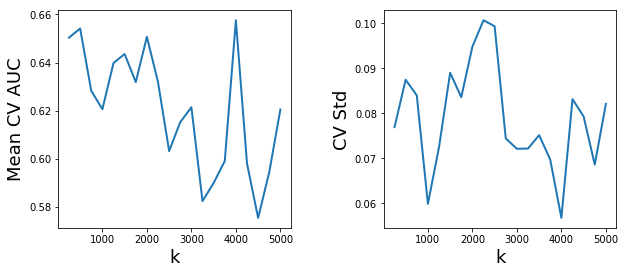

In [430]:
fig, ax = plt.subplots(1, 2, figsize=(10,4)) 
plt.subplots_adjust(wspace = 0.4)

ax1, ax2 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

plt.show()

### F-Value

In [431]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])

for i, k in enumerate(k_vals):
    
    selector = SelectKBest(f_classif, k = k)
    selector.fit(X_train, y_train)
    
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)
     
    rfc = RandomForestClassifier(n_estimators = 25, random_state = 12345, n_jobs = -1)
    scores = cross_val_score(rfc, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6255441967860269
k = 750, Mean CV Score = 0.6345218144237753
k = 1500, Mean CV Score = 0.6394112060778727
k = 2000, Mean CV Score = 0.6448047595106419


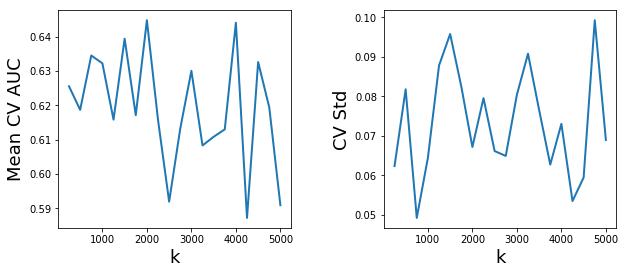

In [432]:
fig, ax = plt.subplots(1, 2, figsize=(10,4)) 
plt.subplots_adjust(wspace = 0.4)

ax1, ax2 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

plt.show()

### Tree Based

In [433]:
max_nf = 5000
max_cv = 0
max_k = 0

step = 250
k_vals = np.arange(step, max_nf + step, step)

cv_score = np.zeros(k_vals.shape[0])
cv_std = np.zeros(k_vals.shape[0])

model = ExtraTreesClassifier(n_estimators = 100, random_state = 12345)
model.fit(X_train, y_train)

for i, k in enumerate(k_vals):
    
    selector = SelectFromModel(model, prefit = True, max_features = k)

    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)

    rfc = RandomForestClassifier(n_estimators = 25, random_state = 12345, n_jobs = -1)
    scores = cross_val_score(rfc, X_train_sel, y_train, cv = 10, scoring = "roc_auc")
    cv = np.mean(scores)
    cvs = np.std(scores)
            
    cv_score[i] = cv
    cv_std[i] = cvs
    
    if cv > max_cv:
        max_cv = cv
        max_k = k
        print("k = {}, Mean CV Score = {}".format(max_k, max_cv))

k = 250, Mean CV Score = 0.6726342103793084


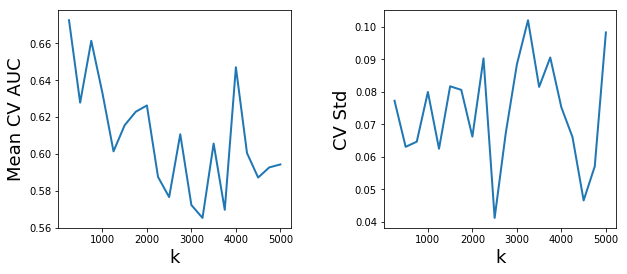

In [434]:
fig, ax = plt.subplots(1, 2, figsize=(10,4)) 
plt.subplots_adjust(wspace = 0.4)

ax1, ax2 = ax

ax1.plot(k_vals, cv_score)
ax1.set_xlabel("k")
ax1.set_ylabel("Mean CV AUC")

ax2.plot(k_vals, cv_std)
ax2.set_xlabel("k")
ax2.set_ylabel("CV Std")

plt.show()

## Plots

In [241]:
max_nf = 5000
step = 250
k_vals = np.arange(step, max_nf + step, step)

lr_tree_scores = np.array([
    0.6905266 , 0.75478186, 0.80793345, 0.83303912, 0.83141724,
    0.83341154, 0.82810178, 0.83248981, 0.84378619, 0.84014953,
    0.8488725 , 0.8440953 , 0.83681265, 0.83690297, 0.83279798,
    0.83750908, 0.83599985, 0.83251122, 0.82937359, 0.8202214 
])

svm_tree_scores = np.array([
    0.70693164, 0.71246578, 0.73006489, 0.73821388, 0.728774  ,
    0.72003612, 0.71140905, 0.711862  , 0.7125128 , 0.70937098,
    0.7031879 , 0.70046971, 0.69682141, 0.6949258 , 0.69406551,
    0.69320988, 0.69075471, 0.68797833, 0.68438449, 0.68179711
])

rfc_tree_scores = np.array([
    0.74343798, 0.74218666, 0.73263226, 0.72990056, 0.73913189,
    0.74593598, 0.72600972, 0.73309685, 0.73880416, 0.73491984,
    0.72758133, 0.74914809, 0.7400918 , 0.73639461, 0.73646537,
    0.74038043, 0.72268309, 0.73620934, 0.74048098, 0.73208108
])

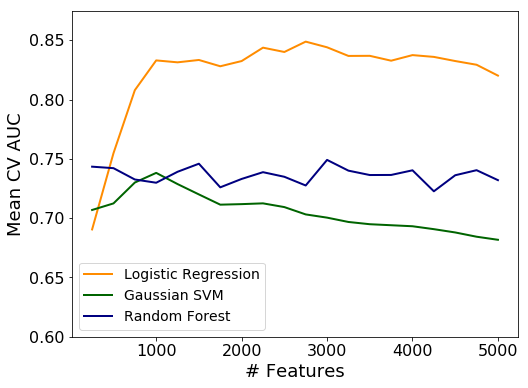

In [242]:
plt.figure(figsize = (8, 6))

plt.plot(k_vals, lr_tree_scores, c = "darkorange", label = "Logistic Regression")
plt.plot(k_vals, svm_tree_scores, c = "darkgreen", label = "Gaussian SVM")
plt.plot(k_vals, rfc_tree_scores, c = "navy", label = "Random Forest")

plt.ylim([0.6, 0.875])

plt.xlabel("# Features")
plt.ylabel("Mean CV AUC")
plt.legend(loc="lower left")

plt.savefig("images/auc_features_model.png", dpi = 300)
plt.show()

# Model Tuning

In this section, we optimize hyperparameters for both an SVM and RF classifier, using the optimal feature subset determined from the above analysis.

In [288]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [289]:
X_train_clinical = X_train[:,0:5]
X_test_clinical = X_test[:,0:5]

X_train_rna = X_train[:,5:]
X_test_rna = X_test[:,5:]

Choose 3500 best features from a tree-based classifier to use in the model.

In [290]:
selector = SelectKBest(t_score, k = 3500)
selector.fit(X_train, y_train)
    
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

In [291]:
top_features = np.argsort(-selector.scores_)
top_features[:25]

array([    4,  2195, 17462, 23059, 12105, 32111, 28616, 14345, 14416,
        7942, 24425, 25525, 30678, 32051, 32042,  8370, 26551, 32108,
       32112, 24152, 32104, 25785, 25781, 18458, 30445])

## PCA Reduction

In [292]:
var = 0
k = 5

while var < 0.9:
    
    pca = PCA(n_components = k, random_state = 12345)
    pca.fit(X_train_sel)
    
    var = np.sum(pca.explained_variance_ratio_)
    
    print("k = {}, Explained variance = {}".format(k, var))
    
    k += 5

k = 5, Explained variance = 0.49958676983469513
k = 10, Explained variance = 0.5782895424422239
k = 15, Explained variance = 0.6200492992338792
k = 20, Explained variance = 0.6469199877925008
k = 25, Explained variance = 0.6678253830383936
k = 30, Explained variance = 0.6848850744995469
k = 35, Explained variance = 0.6986486681664731
k = 40, Explained variance = 0.710490586273076
k = 45, Explained variance = 0.7202815150406335
k = 50, Explained variance = 0.7296604174965834
k = 55, Explained variance = 0.7383811452100377
k = 60, Explained variance = 0.7461516069120703
k = 65, Explained variance = 0.753948996961364
k = 70, Explained variance = 0.7612605707170433
k = 75, Explained variance = 0.7683132531946933
k = 80, Explained variance = 0.7750332770892749
k = 85, Explained variance = 0.7813920649275609
k = 90, Explained variance = 0.7878101979451317
k = 95, Explained variance = 0.7937265567745395
k = 100, Explained variance = 0.7996246377486688
k = 105, Explained variance = 0.805336189

In [293]:
k = 215

pca = PCA(n_components = k, random_state = 12345)
X_train_pca = pca.fit_transform(X_train_sel)
X_test_pca = pca.transform(X_test_sel)

X0_pca = X_train_pca[y_train == 0]
X1_pca = X_train_pca[y_train == 1]

np.sum(pca.explained_variance_ratio_)

0.9031360981682341

/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


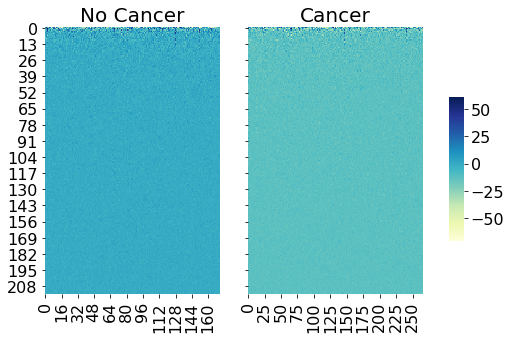

In [272]:
#cmap = sns.diverging_palette(240, 10, sep=20, as_cmap=True)

fig, axn = plt.subplots(1, 2, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

pca_title = ["No Cancer", "Cancer"]
pca_data = [X0_pca, X1_pca]

for i, ax in enumerate(axn.flat):
    ax.set_title(pca_title[i])
    sns.heatmap(pca_data[i].T, ax=ax,
                cbar= i == 0,
                cbar_ax=None if i else cbar_ax,
                cmap="YlGnBu")

fig.tight_layout(rect=[0, 0, .9, 1])

plt.savefig("images/pca_heatmap_selected.png", dpi = 300)
plt.show()

## Logistic Regression

In [344]:
lr = LogisticRegression(solver = 'newton-cg')

parameters = {
    'C': [0.0075, 0.01, 0.025, 0.05],
    'class_weight': [{0: 0.35, 1: 1}, {0: 0.5, 1: 1}, {0: 0.75, 1: 1}, {0: 1, 1: 1},{0: 1.25, 1: 1}, {0: 1.5, 1: 1}]
}

clf = GridSearchCV(lr, parameters, cv = 10, n_jobs = -1, scoring = "roc_auc")
clf.fit(X_train_pca, y_train)

clf.best_params_

/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 0.0075, 'class_weight': {0: 1, 1: 1}}

In [413]:
lr = LogisticRegression(C = 0.0075, solver = 'newton-cg', class_weight = {0: 1, 1: 1})
lr.fit(X_train_pca, y_train)

LogisticRegression(C=0.0075, class_weight={0: 1, 1: 1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [414]:
scores = cross_val_score(lr, X_train_pca, y_train, cv = 10, scoring = "roc_auc")
np.mean(scores)

0.8416457181163064

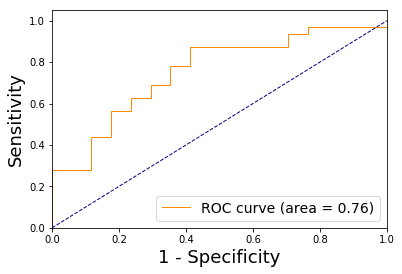

In [415]:
fpr, tpr, roc_auc = calc_roc_auc(lr, X_test_pca, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

In [416]:
y_test_pred = lr.predict(X_test_pca)

sklearn.metrics.confusion_matrix(y_test, y_test_pred)

array([[10,  7],
       [ 4, 28]])

In [417]:
sklearn.metrics.accuracy_score(y_test, y_test_pred), sklearn.metrics.recall_score(y_test, y_test_pred)

(0.7755102040816326, 0.875)

## SVM

In [608]:
svr = svm.SVC(kernel = "rbf", probability = True)

parameters = {
    'C': [1, 2, 3, 4],
    'class_weight': [{0: 1, 1: 1}, {0: 1.1, 1: 1}, {0: 1.25, 1: 1}, {0: 1.5, 1: 1}],
    'gamma': ["auto", "scale"]
}

clf = GridSearchCV(svr, parameters, cv = 10, n_jobs = -1, scoring = "roc_auc")
clf.fit(X_train_pca, y_train)

clf.best_params_

/home/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 1, 'class_weight': {0: 1.5, 1: 1}, 'gamma': 'scale'}

In [629]:
svr = svm.SVC(C = 5, gamma = "scale", class_weight = {0: 1.5, 1: 1}, probability = True)
svr.fit(X_train_pca, y_train)

SVC(C=5, cache_size=200, class_weight={0: 1.5, 1: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [630]:
scores = cross_val_score(svr, X_train_pca, y_train, cv = 10, scoring = "roc_auc")
np.mean(scores)

0.6676731281306445

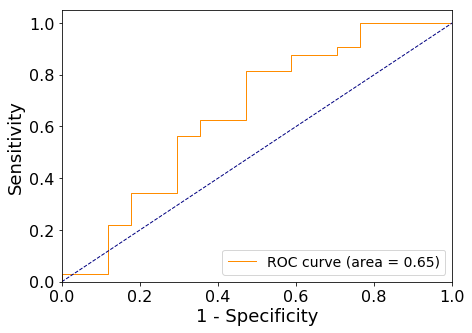

In [631]:
fpr, tpr, roc_auc = calc_roc_auc(svr, X_test_pca, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

In [632]:
y_test_pred = svr.predict(X_test_pca)

sklearn.metrics.confusion_matrix(y_test, y_test_pred)

array([[ 7, 10],
       [ 4, 28]])

In [633]:
sklearn.metrics.recall_score(y_test, y_test_pred)

0.875

## Random Forest

This takes a very long time to run since of the high dimensional parameter space.

In [329]:
rfc = RandomForestClassifier(random_state = 12345)


parameters = {
    'max_features': [0.25, 0.5, 0.75]
}

clf = GridSearchCV(rfc, parameters, cv = 10, n_jobs = -1, scoring = "roc_auc")
clf.fit(X_train_pca, y_train)

clf.best_params_

/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/sfriedowitz/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'max_features': 0.5}

In [161]:
rfc = RandomForestClassifier(n_estimators = 100,
                             max_depth = 5,
                             max_features = 0.005,
                             class_weight = {0: 2.5, 
                                             1: 1},
                             random_state = 12345)

rfc.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 2.5, 1: 1},
            criterion='gini', max_depth=5, max_features=0.005,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=12345, verbose=0, warm_start=False)

In [162]:
scores = cross_val_score(rfc, X_train_pca, y_train, cv = 5, scoring = "roc_auc")
np.mean(scores)

0.6095569931524988

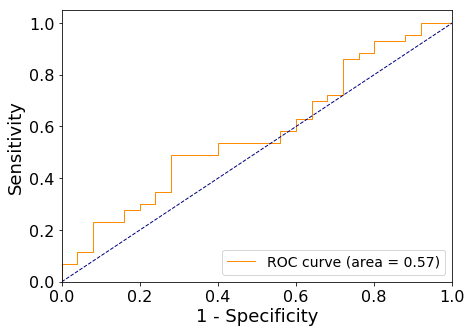

In [163]:
fpr, tpr, roc_auc = calc_roc_auc(rfc, X_test_pca, y_test)

plot_roc_curve(fpr, tpr, roc_auc)

In [164]:
y_test_pred = rfc.predict(X_test_pca)

sklearn.metrics.confusion_matrix(y_test, y_test_pred)

array([[ 1, 24],
       [ 0, 43]])

In [165]:
sklearn.metrics.recall_score(y_test, y_test_pred)

1.0

# Model Testing

In [1561]:
# Pull Data
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values
X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [1562]:
X_train_clinical = X_train[:,0:5]
X_test_clinical = X_test[:,0:5]

X_train_rna = X_train[:,5:]
X_test_rna = X_test[:,5:]

In [244]:
selector = SelectKBest(t_score, k = 3500)
selector.fit(X_train, y_train)
    
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

In [245]:
top_features = np.argsort(-selector.scores_)
top_features[:10]

array([    4,  2195, 17462, 23059, 12105, 32111, 28616, 14345, 14416,
        7942])

In [246]:
pca = PCA(n_components = k, random_state = 12345)
X_train_pca = pca.fit_transform(X_train_sel)
X_test_pca = pca.transform(X_test_sel)

Clinical Model:

In [247]:
lr_clinical = LogisticRegression(solver = 'newton-cg')

lr_clinical.fit(X_train_clinical, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

Full Model:

In [370]:
lr_full = LogisticRegression(C = 0.0075, solver = 'newton-cg', class_weight = {0: 1, 1: 1})

lr_full.fit(X_train_pca, y_train)

LogisticRegression(C=0.0075, class_weight={0: 1, 1: 1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

## Testing

In [377]:
y_clinical_pred = lr_clinical.predict(X_test_clinical)
y_full_pred = lr_full.predict(X_test_pca)

In [378]:
sklearn.metrics.confusion_matrix(y_test, y_clinical_pred)

array([[ 7, 10],
       [ 7, 25]])

In [379]:
sklearn.metrics.confusion_matrix(y_test, y_full_pred)

array([[10,  7],
       [ 4, 28]])

In [420]:
auc_c = cross_val_score(lr_clinical, X_train_clinical, y_train, cv = 10, scoring = "roc_auc")
auc_f = cross_val_score(lr_full, X_train_pca, y_train, cv = 10, scoring = "roc_auc")

auc_c = np.mean(auc_c)
auc_f = np.mean(auc_f)

print("Mean Clincal AUC = {}\nMean Full AUC = {}".format(auc_c, auc_f))

Mean Clincal AUC = 0.6903874085246634
Mean Full AUC = 0.8416457181163064


In [381]:
accuracy_c = sklearn.metrics.accuracy_score(y_test, y_clinical_pred)
accuracy_f = sklearn.metrics.accuracy_score(y_test, y_full_pred)

print("Clinical Accuracy = {}\nFull Accuracy = {}".format(accuracy_c, accuracy_f))

Clinical Accuracy = 0.6530612244897959
Full Accuracy = 0.7755102040816326


In [384]:
precision_c = sklearn.metrics.precision_score(y_test, y_clinical_pred)
precision_f = sklearn.metrics.precision_score(y_test, y_full_pred)

print("Clinical Precision = {}\nFull Precision = {}".format(precision_c, precision_f))

Clinical Precision = 0.7142857142857143
Full Precision = 0.8


In [385]:
recall_c = sklearn.metrics.recall_score(y_test, y_clinical_pred)
recall_f = sklearn.metrics.recall_score(y_test, y_full_pred)

print("Clinical Recall = {}\nFull Recall = {}".format(recall_c, recall_f))

Clinical Recall = 0.78125
Full Recall = 0.875


In [418]:
fpr_c, tpr_c, roc_auc_c = calc_roc_auc(lr_clinical, X_test_clinical, y_test)
fpr_f, tpr_f, roc_auc_f = calc_roc_auc(lr_full, X_test_pca, y_test)

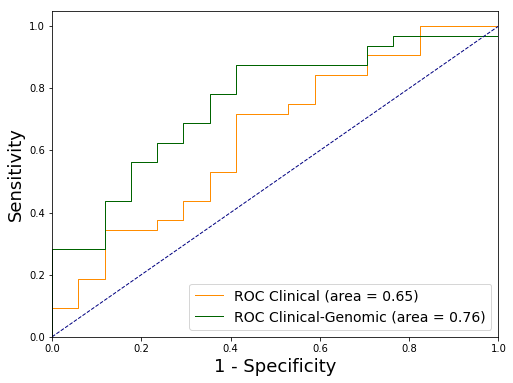

In [419]:
plt.figure(figsize = (8,6))
plt.plot(fpr_c, tpr_c, color='darkorange', lw=1, label='ROC Clinical (area = %0.2f)' % roc_auc_c)
plt.plot(fpr_f, tpr_f, color='darkgreen', lw=1, label='ROC Clinical-Genomic (area = %0.2f)' % roc_auc_f)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc="lower right")

plt.savefig("images/roc_clinical_full.png", dpi = 300)
plt.show()

# Gene Names for Top Genes

In [236]:
top_features = np.array([    
    4,  2195, 17462, 23059, 12105, 32111, 28616, 14345, 14416,
    7942, 24425, 25525, 30678, 32051, 32042,  8370, 26551, 32108,  
    32112, 24152, 32104, 25785, 25781, 18458, 30445
])

tf1 = top_features + 1

Load lookup dictionary (created in parse_data)

In [237]:
f = open('data/gene_dict.pkl','rb')
gene_dict = pickle.load(f)
f.close()

Get the top gene IDs

In [238]:
top_gene_IDs = train_df.iloc[0:1,tf1].columns
top_gene_IDs

Index(['mass_size', '7894737', '8034420', '8091385', '7978123', '8180078',
       '8146092', '8002133', '8002919', '7937217', '8104141', '8115147',
       '8166072', '8179489', '8179331', '7940775', '8125463', '8180049',
       '8180086', '8101774', '8180003', '8117476', '8117435', '8043782',
       '8163678'],
      dtype='object')

The first feature is clinical data. In the below, missing entries have not been identified as genes for a particular mRNA (i.e. if a gene ID is missing we don't know exactly what it is. Affimetrix updates their database twice a year).

In [240]:
best_feats = [['mass_size', ('N/A')]]
best_feats.append( [[i,gene_dict[i]] for i in top_gene_IDs[1:] if (i in gene_dict)] )
best_feats

[['mass_size', 'N/A'],
 [['8034420', ('MAN2B1',)],
  ['8091385', ('CP',)],
  ['7978123', ('PSME2',)],
  ['8180078', ('HLA-DMB',)],
  ['8146092', ('IDO1',)],
  ['8002133', ('PSMB10',)],
  ['8002919', ('KARS',)],
  ['7937217', ('ECHS1',)],
  ['8104141', ('PLEKHG4B',)],
  ['8115147', ('CD74',)],
  ['8166072', ('TMSB4XP6', 'TMSB4X')],
  ['8179489', ('HLA-DQA2', 'HLA-DQA1')],
  ['8179331', ('C2',)],
  ['7940775', ('RARRES3',)],
  ['8125463', ('HLA-DQB2',)],
  ['8180049', ('PSMB8',)],
  ['8180086', ('HLA-DMA', 'HLA-DMB')],
  ['8101774', ('TMSB4X',)],
  ['8117476', ('BTN3A3',)],
  ['8117435', ('BTN3A2',)],
  ['8043782', ('CNGA3',)],
  ['8163678', ('ASTN2',)]]]

Gene Identities (from genecards.org) 

MAN2B1 (8034420) - Mannosidase Alpha Class 2B Member 1, necessary for the catabolism of N-linked carbohydrates released during glycoprotein turnover

CP (8091385) - Ceruloplasmin, relatred to Fe transport across cell membrane, plays role in fetal lung development

PSME2 (7978123) - Proteosome Activator Subunit 2, related to cell cycle/mitotic/RET signaling pathways

HLA-DMB (8180078) - Major Histocompatibility Complex, Class II, DM Beta, membrane peptide binding and antigen binding, cellular signaling

IDO1 (8146092) - Indoleamine 2,3-Dioxygenase, catalyzed tryptophan metabolism, acts as a suppressor of anti-tumor immunity

KARS (8002919) - Lysyl-TRNA Synthetase, catalyzes tRNA charging, linked to immune response through monocyte/macrophage signaling

CD74 (8115147) - CD74 Molecule, chaperones antigen presentation for immne response